## Import

In [ ]:
%load_ext autoreload
%autoreload 2
import logging

import seaborn as sns

import core.config as cfg
import core.finance as fin
import helpers.dbg as dbg
import helpers.env as env
import helpers.printing as pri
import vendors.kibot.utils as kut

In [ ]:
print(env.get_system_signature())

pri.config_notebook()

# TODO(gp): Changing level during the notebook execution doesn't work. Fix it.
# dbg.init_logger(verb=logging.DEBUG)
dbg.init_logger(verb=logging.INFO)
# dbg.test_logger()

_LOG = logging.getLogger(__name__)

# Metadata

In [4]:
df1 = kut.read_metadata1()
df1.head(3)

,Symbol,Link,Description
1,JY,http://api.kibot.com/?action=download&link=151...,CONTINUOUS JAPANESE YEN CONTRACT
2,JYF18,http://api.kibot.com/?action=download&link=vrv...,JAPANESE YEN JANUARY 2018
3,JYF19,http://api.kibot.com/?action=download&link=8r8...,JAPANESE YEN JANUARY 2019


In [5]:
df2 = kut.read_metadata2()
df2.head(3)

,Symbol,Link,Description
1,JY,http://api.kibot.com/?action=download&link=151...,CONTINUOUS JAPANESE YEN CONTRACT
2,JYF18,http://api.kibot.com/?action=download&link=vrv...,JAPANESE YEN JANUARY 2018
3,JYF19,http://api.kibot.com/?action=download&link=8r8...,JAPANESE YEN JANUARY 2019


In [6]:
df3 = kut.read_metadata3()
df3.head(3)

,SymbolBase,Symbol,StartDate,Size(MB),Description,Exchange
1,ES,ES,9/30/2009,50610.0,CONTINUOUS E-MINI S&P 500 CONTRACT,Chicago Mercantile Exchange Mini Sized Contrac...
2,ES,ESH11,4/6/2010,891.0,E-MINI S&P 500 MARCH 2011,Chicago Mercantile Exchange Mini Sized Contrac...
3,ES,ESH12,3/6/2011,1060.0,E-MINI S&P 500 MARCH 2012,Chicago Mercantile Exchange Mini Sized Contrac...


In [7]:
df4 = kut.read_metadata4()
print(df4.head(3))

print(df4["Exchange"].unique())

  SymbolBase Symbol  StartDate  Size(MB)                                 Description                                  Exchange
1         JY     JY  9/27/2009     183.0            CONTINUOUS JAPANESE YEN CONTRACT  Chicago Mercantile Exchange (CME GLOBEX)
2         TY     TY  9/27/2009     180.0  CONTINUOUS 10 YR US TREASURY NOTE CONTRACT      Chicago Board Of Trade (CBOT GLOBEX)
3         FV     FV  9/27/2009     171.0   CONTINUOUS 5 YR US TREASURY NOTE CONTRACT      Chicago Board Of Trade (CBOT GLOBEX)
['Chicago Mercantile Exchange (CME GLOBEX)'
 'Chicago Board Of Trade (CBOT GLOBEX)'
 'Chicago Mercantile Exchange Mini Sized Contracts (CME MINI)'
 'Commodities Exchange Center (COMEX GLOBEX)'
 'New York Mercantile Exchange (NYMEX GLOBEX)'
 'Chicago Board Of Trade Mini Sized Contracts (CBOT MINI)'
 'New York Mercantile Exchange Mini Sized Contracts'
 'CBOE Futures Exchange (CFE)']


## Explore metadata

In [8]:
mask = ["GAS" in d or "OIL" in d for d in df4["Description"]]
print(sum(mask))
print(df4[mask].drop(["SymbolBase", "Size(MB)"], axis=1))

7
   Symbol  StartDate                                   Description                                           Exchange
10     CL  9/27/2009                 CONTINUOUS CRUDE OIL CONTRACT        New York Mercantile Exchange (NYMEX GLOBEX)
20     NG  9/27/2009               CONTINUOUS NATURAL GAS CONTRACT        New York Mercantile Exchange (NYMEX GLOBEX)
24     QM  9/27/2009          CONTINUOUS E-MINI CRUDE OIL CONTRACT  New York Mercantile Exchange Mini Sized Contracts
29     RB  9/27/2009             CONTINUOUS RBOB GASOLINE CONTRACT        New York Mercantile Exchange (NYMEX GLOBEX)
35     BO  9/27/2009               CONTINUOUS SOYBEAN OIL CONTRACT               Chicago Board Of Trade (CBOT GLOBEX)
43     BZ  9/28/2009  CONTINUOUS BRENT CRUDE OIL LAST DAY CONTRACT        New York Mercantile Exchange (NYMEX GLOBEX)
49     QG  9/27/2009        CONTINUOUS E-MINI NATURAL GAS CONTRACT  New York Mercantile Exchange Mini Sized Contracts


# Read data

In [ ]:
config = cfg.Config.from_env()

if config is None:
    config = cfg.Config()
    config_tmp = config.add_subconfig("read_data")
    # config_tmp["nrows"] = 100000
    config_tmp["nrows"] = None
    #
    config["zscore_com"] = 28

print(config)

# Prices

## Read daily prices

In [ ]:
symbols = "CL NG RB BZ".split()
file_name = (
    "s3://alphamatic/kibot/All_Futures_Continuous_Contracts_daily/%s.csv.gz"
)

daily_price_dict_df = kut.read_multiple_symbol_data(
    symbols, file_name, nrows=config["read_data"]["nrows"]
)

daily_price_dict_df["CL"].tail(2)

In [11]:
col_name = "close"
mode = "pct_change"
daily_rets = kut.compute_ret_0_from_multiple_daily_prices(
    daily_price_dict_df, col_name, mode
)

daily_rets.head(3)

,CL_ret_0,NG_ret_0,RB_ret_0,BZ_ret_0
date,,,,
1995-12-22,NaN,NaN,NaN,NaN
1995-12-26,NaN,0.042230,NaN,NaN
1995-12-27,NaN,0.162075,NaN,NaN


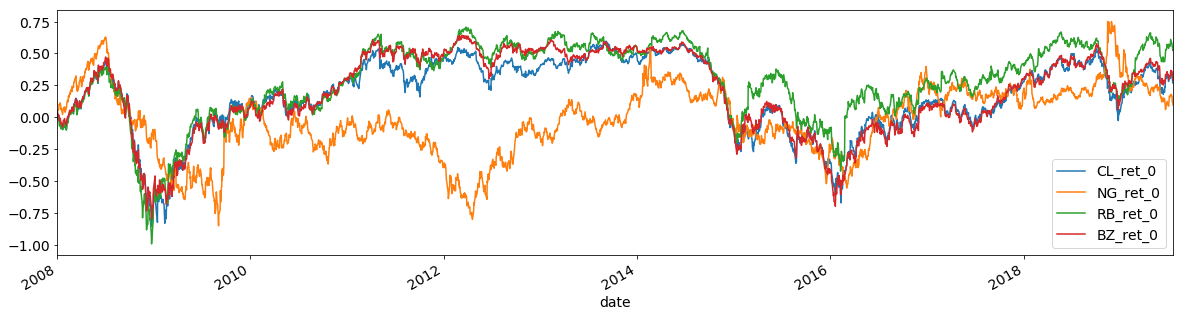

In [12]:
daily_rets = daily_rets["2008-01-01":]
daily_rets.fillna(0.0).cumsum().plot()

In [13]:
daily_zrets = fin.zscore(
    daily_rets, com=config["zscore_com"], demean=False, standardize=True, delay=1
)
daily_zrets.columns = [c.replace("ret_", "zret_") for c in daily_zrets.columns]
daily_zrets.dropna().head(3)

,CL_zret_0,NG_zret_0,RB_zret_0,BZ_zret_0
date,,,,
2008-05-02,1.657053,0.843458,1.488304,1.971953
2008-05-05,1.502575,1.549153,1.393845,1.540747
2008-05-06,0.736002,-0.102685,0.815882,0.996586


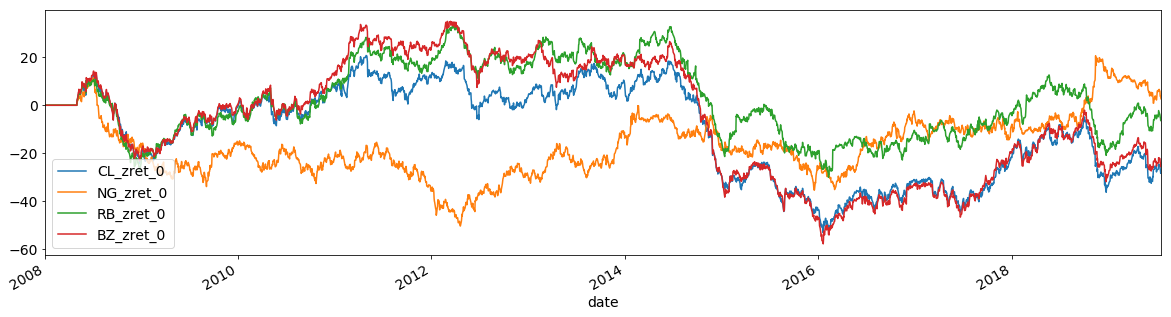

In [14]:
daily_zrets = daily_zrets["2008-01-01":]

daily_zrets.fillna(0.0).cumsum().plot()

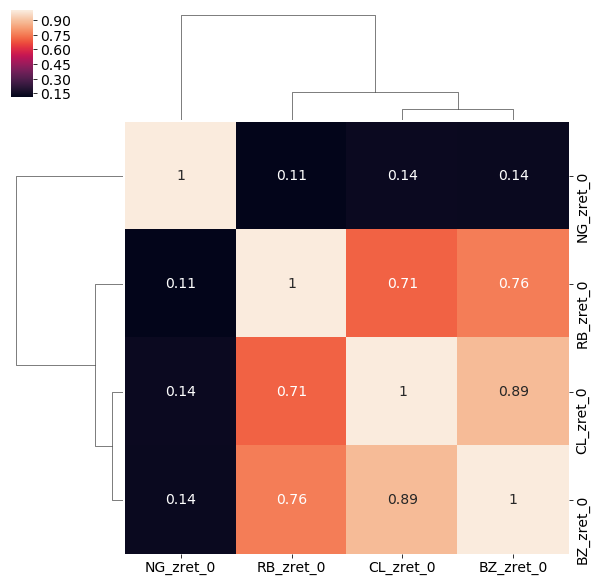

In [15]:
annot = True
stocks_corr = daily_zrets.corr()

sns.clustermap(stocks_corr, annot=annot)

In [16]:
print(daily_zrets.head(2))
daily_rets.to_csv("oil_daily_zrets.csv")

            CL_zret_0  NG_zret_0  RB_zret_0  BZ_zret_0
date                                                  
2008-01-02        NaN        NaN        NaN        NaN
2008-01-03        NaN        NaN        NaN        NaN


## Read 1 min prices

In [ ]:
symbols = "CL NG RB BZ".split()
file_name = (
    "s3://alphamatic/kibot/All_Futures_Continuous_Contracts_1min/%s.csv.gz"
)
min_price_dict_df = kut.read_multiple_symbol_data(
    symbols, file_name, nrows=config["read_data"]["nrows"]
)

min_price_dict_df["CL"].tail(2)

In [18]:
min_price_dict_df.keys()

dict_keys(['CL', 'NG', 'RB', 'BZ'])

In [19]:
mode = "pct_change"
min_rets = kut.compute_ret_0_from_multiple_1min_prices(min_price_dict_df, mode)

min_rets.head(3)

,CL_ret_0,NG_ret_0,RB_ret_0,BZ_ret_0
datetime,,,,
2009-09-27 18:00:00,NaN,NaN,NaN,NaN
2009-09-27 18:01:00,0.003175,-0.001261,NaN,NaN
2009-09-27 18:02:00,0.000151,NaN,NaN,NaN


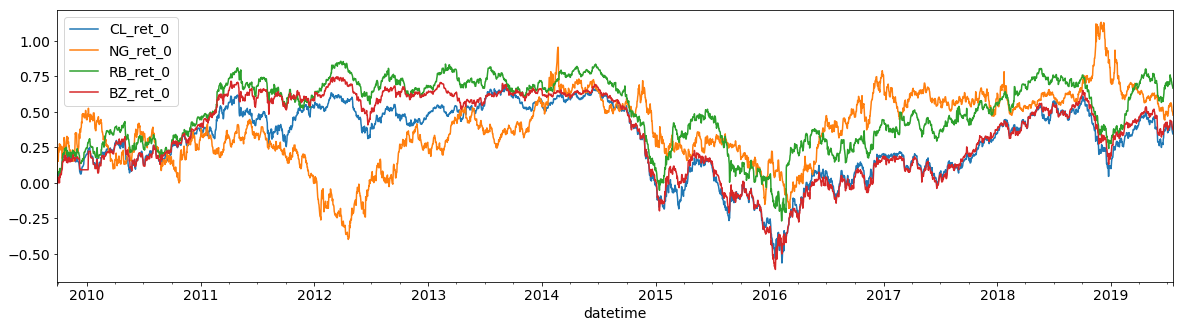

In [20]:
min_rets.fillna(0.0).resample("1D").sum().cumsum().plot()

In [21]:
min_zrets = fin.zscore(
    min_rets, com=config["zscore_com"], demean=False, standardize=True, delay=1
)
min_zrets.columns = [c.replace("ret_", "zret_") for c in min_zrets.columns]
min_zrets.dropna().head(3)

,CL_zret_0,NG_zret_0,RB_zret_0,BZ_zret_0
datetime,,,,
2009-10-27 09:42:00,-2.584533,-1.827151,-2.918805,0.779308
2009-10-27 10:27:00,2.257138,2.158523,0.739084,3.398863
2009-10-27 10:29:00,-0.933710,0.691642,0.623041,0.234402


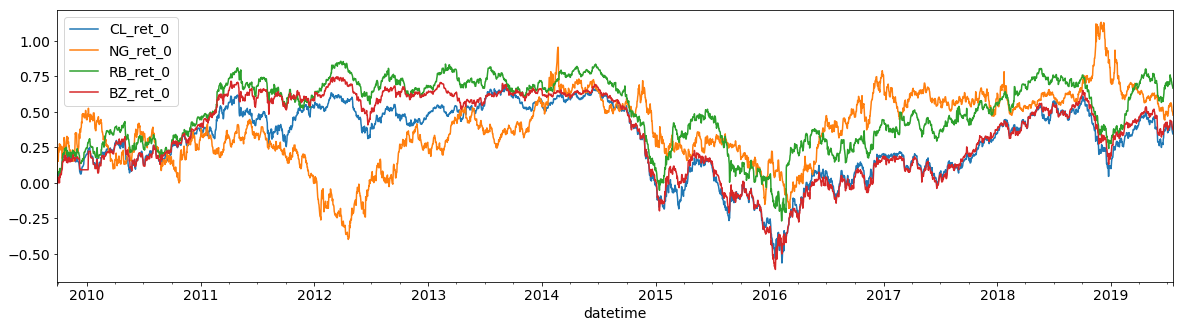

In [22]:
min_zrets = min_rets["2008-01-01":]

min_zrets.fillna(0.0).resample("1d").sum().cumsum().plot()

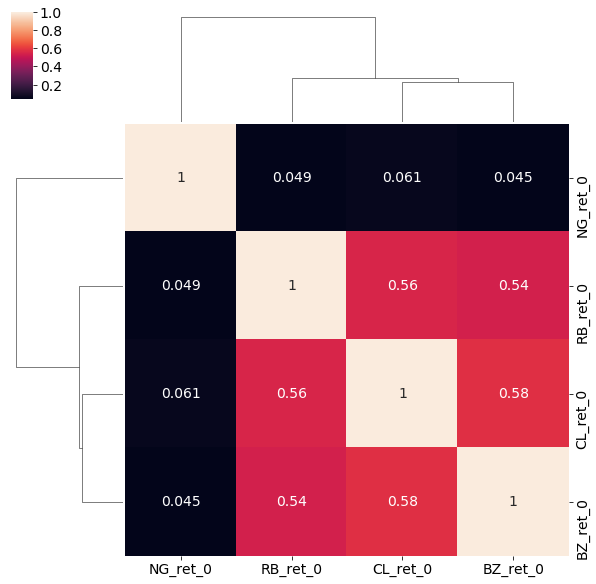

In [23]:
annot = True
stocks_corr = min_rets.corr()

sns.clustermap(stocks_corr, annot=annot)

In [24]:
print(min_zrets.head(2))
min_zrets.to_csv("oil_1min_zrets.csv")

                     CL_ret_0  NG_ret_0  RB_ret_0  BZ_ret_0
datetime                                                   
2009-09-27 18:00:00       NaN       NaN       NaN       NaN
2009-09-27 18:01:00  0.003175 -0.001261       NaN       NaN
